<a href="http://landlab.github.io"><img style="float: left" src="../../media/landlab_header.png"></a>

# Large scale landscape evolution model with Priority flood flow router and Space_v2
<hr>

The priority flood flow director is designed to calculate flow properties over large scale grids. In the following notebook we illustrate how the priority flood flow accumulator can be used to simulate landscape evolution using the SPAVE_V2 Landlab component

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import time
import copy
import matplotlib as mpl

from landlab import imshow_grid,imshowhs_grid, RasterModelGrid
from landlab.components import (
    FlowAccumulator,
    DepressionFinderAndRouter,
    SpaceLargeScaleEroder,
    PriorityFloodFlowRouter,
    LateralEroderSolo, 
    FastscapeEroder,
    BedrockLandslider
)

Below is a fancy plotting function from BC's bedrocklandslides_on_DEMs notebook

In [2]:
def plotting(
    grid, topo=True, DA=True, hill_DA=False, flow_metric="D8", hill_flow_metric="Quinn"
):
    if topo:
        cmap = copy.copy(mpl.cm.get_cmap("terrain"))
        azdeg = 200
        altdeg = 20
        ve = 1
        plt.figure()
        plot_type = "DEM"
        ax = imshowhs_grid(
            grid,
            "topographic__elevation",
            grid_units=("deg", "deg"),
            var_name="Topo, m",
            cmap=cmap,
            plot_type=plot_type,
            vertical_exa=ve,
            azdeg=azdeg,
            altdeg=altdeg,
            default_fontsize=12,
            cbar_tick_size=10,
            cbar_width="100%",
            cbar_or="vertical",
            bbox_to_anchor=[1.03, 0.3, 0.075, 14],
            colorbar_label_y=-15,
            colorbar_label_x=0.5,
            ticks_km=False,
        )
    if DA:
        # %% Plot first instance of drainage_area
        grid.at_node["drainage_area"][grid.at_node["drainage_area"] == 0] = (
            grid.dx * grid.dx
        )
        plot_DA = np.log10(grid.at_node["drainage_area"] * 111e3 * 111e3)

        plt.figure()
        plot_type = "Drape1"
        drape1 = plot_DA
        thres_drape1 = None
        alpha = 0.5
        myfile1 = "temperature.cpt"
        cmap1 = copy.copy(mpl.cm.get_cmap("terrain"))
        ax = imshowhs_grid(
            grid,
            "topographic__elevation",
            grid_units=("deg", "deg"),
            cmap=cmap1,
            plot_type=plot_type,
            drape1=drape1,
            vertical_exa=ve,
            azdeg=azdeg,
            altdeg=altdeg,
            thres_drape1=thres_drape1,
            alpha=alpha,
            default_fontsize=12,
            cbar_tick_size=10,
            var_name="$log^{10}DA, m^2$",
            cbar_width="100%",
            cbar_or="vertical",
            bbox_to_anchor=[1.03, 0.3, 0.075, 14],
            colorbar_label_y=+5,
            colorbar_label_x=0.5,
            ticks_km=False,
        )

        props = dict(boxstyle="round", facecolor="white", alpha=0.6)
        textstr = flow_metric
        ax.text(
            0.05,
            0.95,
            textstr,
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment="top",
            bbox=props,
        )

Create raster grid with space

In [3]:
# nr = 20
# nc = 20
nr = 75
nc = 75
xy_spacing = 10.0
mg = RasterModelGrid((nr, nc), xy_spacing=xy_spacing)
z = mg.add_zeros("topographic__elevation", at="node")
mg.at_node["topographic__elevation"][mg.core_nodes] += np.random.rand(
    mg.number_of_core_nodes
)

s = mg.add_zeros("soil__depth", at="node", dtype=float)
mg.at_node["soil__depth"][mg.core_nodes] += 0.5
mg.at_node["topographic__elevation"] += mg.at_node["soil__depth"]

fr = PriorityFloodFlowRouter(mg, flow_metric="D8", update_flow_depressions=True)
# fr = PriorityFloodFlowRouter(
#     mg,
#     surface="topographic__elevation",
#     flow_metric="D8",
#     suppress_out=True,
#     depression_handler="fill",
#     accumulate_flow=True,
#     separate_hill_flow=True,
#     accumulate_flow_hill=True,
# )
ha = SpaceLargeScaleEroder(mg, K_sed=0.00005, K_br=0.00005, phi=0.3, H_star=1)

br = mg.at_node["bedrock__elevation"]
z = mg.at_node["topographic__elevation"]

space_dt = 500

In [4]:
z_ori = np.array(z)
t1 = time.time()
for i in tqdm(range(500)):
    # Uplift
    br[mg.core_nodes] += 0.001 * space_dt

    z[mg.core_nodes] = br[mg.core_nodes] + s[mg.core_nodes]

    fr.run_one_step()
    ha.run_one_step(dt=space_dt)

t_span1 = time.time() - t1
print('Total run time is %.f s' %t_span1)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:46<00:00, 10.65it/s]

Total run time is 47 s


# NOTE, END OF THE DAY THURSDAY. this thing keeps digging holes. Why?

OK, not anymore. Changed uplift back to 0.001 from 0.0001 and opened boundaries.

Text(0.5, 1.0, 'Soil Depth')

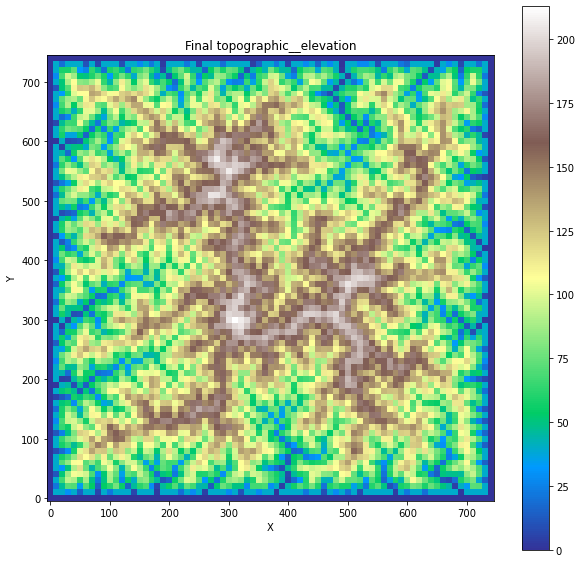

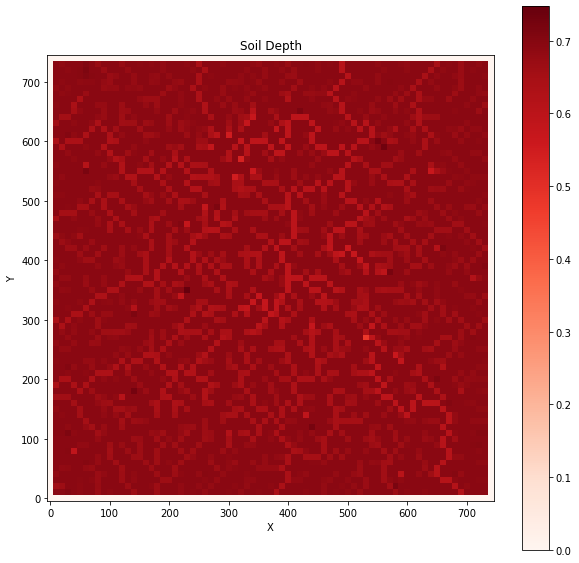

In [5]:
plt.figure(figsize=(10,10))
imshow_grid(mg, "topographic__elevation", cmap="terrain")
plt.title("Final topographic__elevation")
plt.figure(figsize=(10,10))
imshow_grid(mg, "soil__depth", cmap="Reds")
plt.title("Soil Depth")

Instantiate the lateral erosion component.

In [6]:
le = LateralEroderSolo(mg, Kv=0.00005, Kl_ratio = 3)
new_dt = 50

Run lateral erosion and space

In [7]:
z_ori = np.array(z)
t1 = time.time()
for i in tqdm(range(100)):
    # Uplift
    br[mg.core_nodes] += 0.001 * new_dt
    z[mg.core_nodes] = br[mg.core_nodes] + s[mg.core_nodes]
    fr.run_one_step()
    ha.run_one_step(dt=new_dt)
    le.run_one_step_basic(dt=new_dt)

t_span1 = time.time() - t1
print('Total run time is %.f s' %t_span1)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.06it/s]

Total run time is 49 s


Text(0.5, 1.0, 'Cumulative Lateral Erosion')

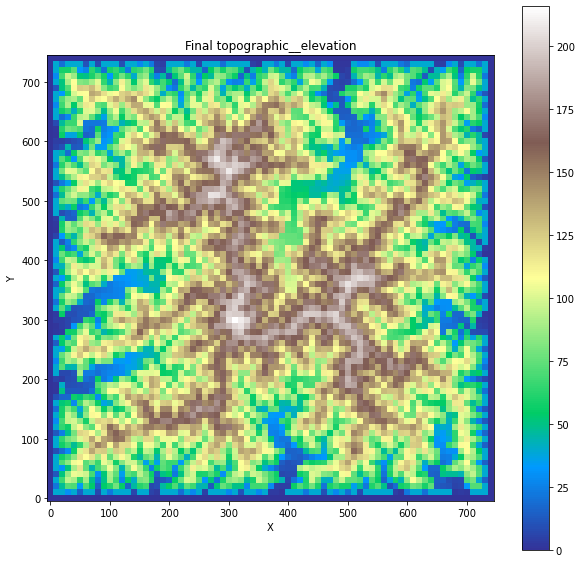

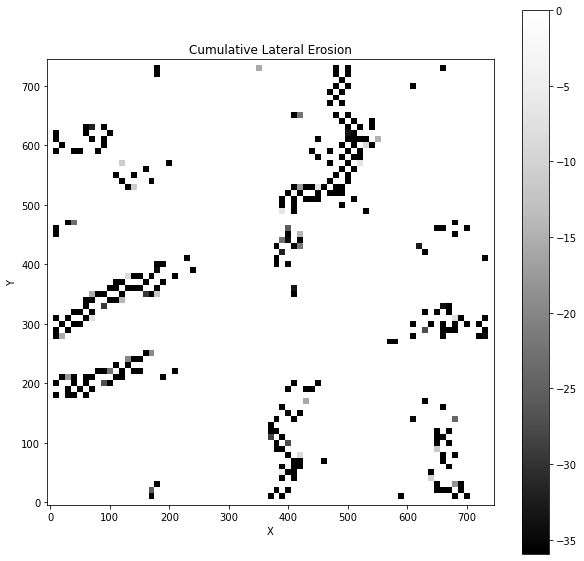

In [8]:
plt.figure(figsize=(10,10))
imshow_grid(mg, "topographic__elevation", cmap="terrain")
plt.title("Final topographic__elevation")
plt.figure(figsize=(10,10))
imshow_grid(mg, "lateral_erosion__depth_cum", cmap="Greys_r", vmin=np.min(mg.at_node["lateral_erosion__depth_cum"])*0.5)
plt.title("Cumulative Lateral Erosion")

Now add landslides. Landslides needs the separate hill slope flow stuff below

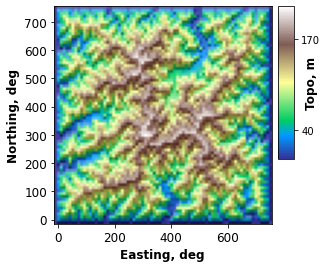

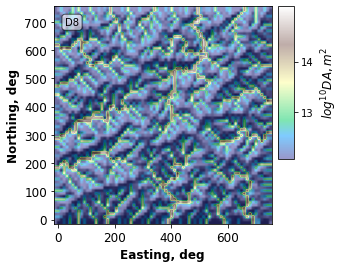

In [10]:
# Here, we only calculate flow directions using the first instance of the flow accumulator
flow_metric = "D8"
fa_PF = PriorityFloodFlowRouter(
    mg,
    surface="topographic__elevation",
    flow_metric=flow_metric,
    suppress_out=True,
    depression_handler="fill",
    accumulate_flow=True,
    separate_hill_flow=True,
    accumulate_flow_hill=True,
)

fa_PF.run_one_step()

# Plot output products
plotting(mg)

In [11]:
ls = BedrockLandslider(
    mg, 
    angle_int_frict=.5,
    landslides_return_time=1e3,
    cohesion_eff = 1e3,)


In [12]:
ls.run_one_step(dt=50)

(0.0, 686290.24129529856)

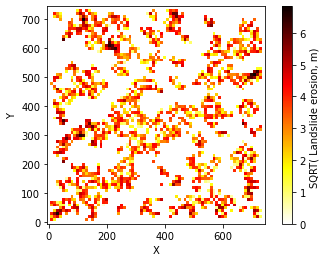

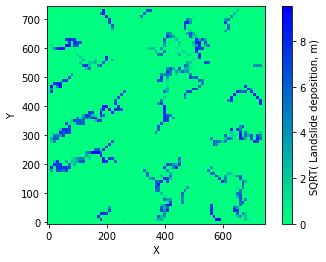

In [13]:
# Landslide Erosion 
cmap = copy.copy(mpl.cm.get_cmap("hot_r"))
imshow_grid(mg,np.sqrt(mg.at_node["landslide__erosion"]), colorbar_label = 'SQRT( Landslide erosion, m) ',cmap =cmap)
plt.show()

# Landslide Deposition 
cmap = copy.copy(mpl.cm.get_cmap("winter_r"))
imshow_grid(mg,np.sqrt(mg.at_node["landslide__deposition"]), colorbar_label = 'SQRT( Landslide deposition, m) ',cmap =cmap)
plt.show()